In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("blockchainTable.csv")


Lets have a look at the minetime, difficulty, and the size of the block to examine if they have any relation to mining power. 


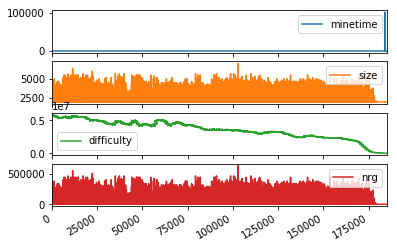

In [41]:
df_plot_line = df[['minetime','size','difficulty','nrg']]
axes = df_plot_line.plot.line(subplots=True)
#fig, axes = plt.subplots(nrows=4, ncols=1)
#for i, c in enumerate(df_plot_line.columns):
    #df_plot_line[c].plot(kind='line', ax=axes[i], figsize=(8, 6), title=c)
plt.show()

It is clear that minetime, nrg consumed, and size do not carry much information at this point as they rarely vary.

Let us have a look at how often the minetime spikes, or exceeds the mean behavior

In [42]:
mean_minetime = round(np.mean(df.minetime),2)
print("mean_minetime is {}".format(round(mean_minetime,2)))
df_qry_minetime = df.query('minetime > '+ str(mean_minetime))
print("% of records in which minetime > mean_minetime is {}%".format(
    round(len(df_qry_minetime.index)/len(df.index),2)*100))
#print(df_qry_minetime)

mean_minetime is 10.47
% of records in which minetime > mean_minetime is 34.0%


Let us look at a correlation heatmap.

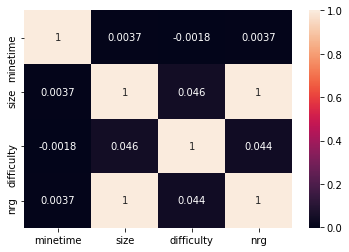

In [43]:
df_temp = df[["minetime", "size", "difficulty", "nrg"]]
corr = df_temp.corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True)
plt.show()

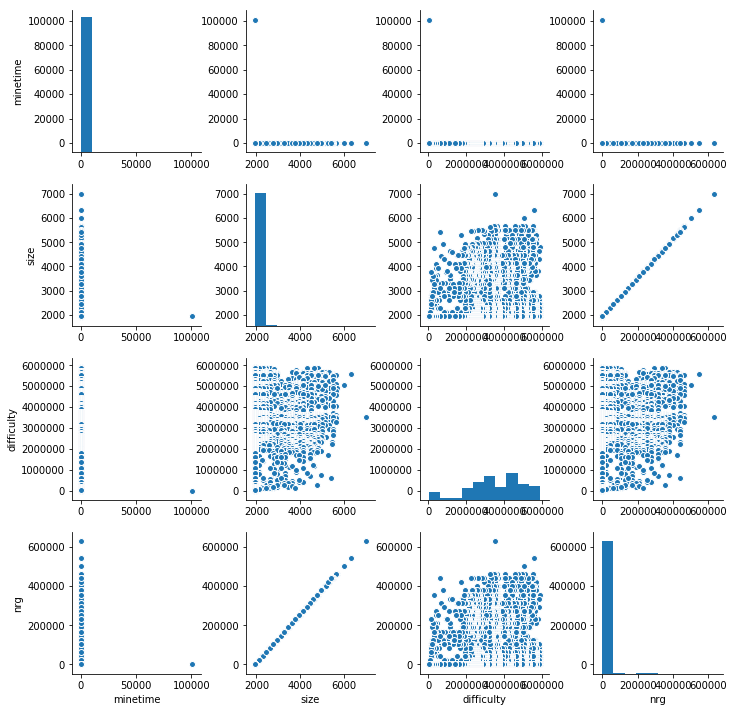

In [44]:
sns.pairplot(df_temp)
plt.show()

In [45]:
df_group = df.groupby(["minuteOfDay","dayOfYear","year"], as_index=False).aggregate({"blockNumber":"count","difficulty":"mean"})
corr=df["blockNumber"].corr(df["difficulty"])
#print(df_group)


print("Here we also examine the correlation between blocks per minute and difficult.")
if corr > .6:
    print("It is evident that there  is a really strong correlation with r = {}".format(corr))
    
    

Here we also examine the correlation between blocks per minute and difficult.
It is evident that there  is a really strong correlation with r = 0.9524577995296386


We know that there is some relationship between blocks mined per minute and difficulty.
When we examine the scatter plot there seems to be evidence of a relationship.
The trend line shows that an inverse relationship between difficulty and the number of blocks mined per minute


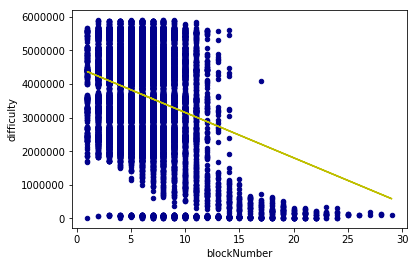

In [46]:
axes = df_group.plot.scatter(x='blockNumber', y='difficulty', c='DarkBLue')

# lets put in a trend line
z = np.polyfit(df_group.blockNumber.tolist(), df_group.difficulty.tolist(), 1)
p = np.poly1d(z)
axes.plot(df_group.blockNumber.tolist(),p(df_group.blockNumber.tolist()),'y')
plt.show()


The graph below shows the number of blocks mined vs minerAddress

At present there are 213 miners on the network


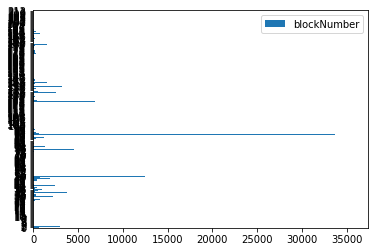

In [47]:
df_group = df.groupby(["minerAddress"], as_index=False).agg({'blockNumber':'count'})
print("At present there are {} miners on the network".format(len(df_group)))
axes = df_group.plot.barh()
plt.show()

In [48]:
df_group = df.groupby(['minerAddress',"dayOfYear"], 
                      as_index=False).aggregate({"blockNumber":"count","difficulty":"mean"})

cols = ["difficulty","nrg","minetime","size"]
for col in cols:
    corr=df["blockNumber"].corr(df[col])
    print("\nHere we also examine the correlation between blocks mined per minute and {}.".format(col))
    if corr > .7:
        print("It is evident that there  is a really strong correlation with r = {}".format(corr))
    elif corr > 0.5:
        print("There  is a really medium strength correlation with r = {}".format(corr))
    elif corr > 0.3:
        print("There  is a really weak correlation with r = {}".format(corr))
    else:
        print("There  is almost no correlation with r = {}".format(corr))


Here we also examine the correlation between blocks mined per minute and difficulty.
It is evident that there  is a really strong correlation with r = 0.9524577995296386

Here we also examine the correlation between blocks mined per minute and nrg.
There  is almost no correlation with r = 0.039761036764076635

Here we also examine the correlation between blocks mined per minute and minetime.
There  is almost no correlation with r = -0.0012428426958908463

Here we also examine the correlation between blocks mined per minute and size.
There  is almost no correlation with r = 0.04210456185760161


Therefore what we want to examine is if there is a relationship between miner address and the difficulty.
Lets do an anova test of means to see if there is any difference.
With a p-value<.001, at least two miners differ in the number of blocks mined according to difficulty

In [49]:
grps = pd.unique(df.minerAddress.values)
d_data = {grp:df['difficulty'][df.minerAddress == grp] for grp in grps}
 
k = len(pd.unique(df.minerAddress))  # number of conditions
N = len(df.values)  # conditions times participants
n = df.groupby('minerAddress').size()[0] #Participants in each condition


import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols('difficulty ~ minerAddress',
                data=df).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                    sum_sq        df           F  PR(>F)
minerAddress  1.490567e+17     212.0  618.098973     0.0
Residual      2.101322e+17  184729.0         NaN     NaN


Summary of the exploratory data analysis:
There is a relationship between difficulty and blocks mined by period, and a relationship between miner 
and blocks mined by period.    


Let us now do some post hoc tests to examine what percentage of miner pairs differ.
If sufficient pairs differ, then it is worth attempting to develop a model based on difficulty.

In [50]:
#make pairs of unique combinations of address
list = df.minerAddress.unique()
pairs = []
for i, item in enumerate(list):
    j = i+1
    while (j  < len(list)):
        pairs.append((list[i],list[j]))
        j += 1 
           
print("There are {} combinations of miner address pairs" .format(len(pairs)))
      
# run the post hoc tests and get percentage of differences
# we use the mann u whitney test since we have not idea of the distribution of the data
from scipy import stats

df_temp = df[["minerAddress", "difficulty"]]
count_differences = 0
pair_counter = 0
for pair in pairs:
    # filter to obtian list of difficultys for each minerAddress
    df0 = df_temp[df_temp["minerAddress"] == pair[0]]
    df1 = df_temp[df_temp["minerAddress"] == pair[1]]
               
               
    pvalue = stats.mannwhitneyu(df0.difficulty.tolist(),df1.difficulty.tolist()).pvalue
   
    if pvalue <0.05:
        count_differences += 1
        
    pair_counter +=1
    #print("pair counter:{}".format(pair_counter))

print("% statistically significant differences between minerAddress pairs = {}%".
     format(round(count_differences*100/len(pairs)),3))


There are 22578 combinations of miner address pairs
% statistically significant differences between minerAddress pairs = 82%


The high percentage return rate of statistically significant differences between miner pairs when looking at difficulty
confirm that theree is indeed a relationship between difficulty and miner address. 
This suggests that there it is possible to come up with some kind of model that (in light of the trendline) relating difficulty and mining rate per period,  with mining power (output).


NEXT STEP(s)
---------------------------------- 
The next step is to use some number of known mining power associated with minerAddresses, to deliver a reasonably accurate model using difficulty and mining rate as the independent variable. This model can be used going forward, and tweaked based on regular recalculation.

In the absence of a good model with reasonable accuracy (from the two inputs above), at the very least we can provide some sort of min/max or percentile ranking based on block mined by period. 